# Food Delivery Market Analysis - Flanders Region

## Project Overview
Analyzing delivery data from Flanders to uncover actionable insights for restaurant partners and consumers.

**Team:** [Your Team Names]  
**Date:** 27 June 2025  
**Duration:** 3 days  

---

## Mission Objectives
- Explore trends, customer preferences, and market dynamics in the food delivery space
- Answer key business questions using SQL operations (SELECT, JOIN, GROUP BY, Aggregations)
- Visualize data insights and build compelling data narratives
- Identify opportunities for restaurant partners and market optimization

---

## Database Structure Overview
- **restaurants**: Restaurant details, ratings, delivery info, coordinates
- **locations**: Postal codes and geographic coordinates for Belgian cities  
- **menuItems**: Individual food items with prices and descriptions
- **categories**: Menu item categories (pizza, pasta, etc.)
- **categories_restaurants**: Maps restaurants to cuisine categories
- **locations_to_restaurants**: Maps restaurants to service locations

In [3]:
# Import required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Database connection
conn = sqlite3.connect('../database/takeaway.db')

print("✅ Libraries imported successfully!")
print("✅ Database connection established!")

✅ Libraries imported successfully!
✅ Database connection established!


## 1. Database Exploration & Data Understanding

In [4]:
# Get overview of all tables
tables_query = """
SELECT 'restaurants' AS table_name, COUNT(*) AS record_count FROM restaurants
UNION ALL
SELECT 'locations', COUNT(*) FROM locations
UNION ALL
SELECT 'menuItems', COUNT(*) FROM menuItems
UNION ALL
SELECT 'categories', COUNT(*) FROM categories
UNION ALL
SELECT 'categories_restaurants', COUNT(*) FROM categories_restaurants
UNION ALL
SELECT 'locations_to_restaurants', COUNT(*) FROM locations_to_restaurants;
"""

table_overview = pd.read_sql_query(tables_query, conn)
print("📊 Database Overview:")
print(table_overview.to_string(index=False))

# Quick data quality check
print("\n🔍 Data Quality Check:")
restaurants_df = pd.read_sql_query("SELECT * FROM restaurants LIMIT 5", conn)
print(f"Restaurants sample shape: {restaurants_df.shape}")
print(f"Restaurants columns: {list(restaurants_df.columns)}")

menu_df = pd.read_sql_query("SELECT * FROM menuItems WHERE price IS NOT NULL LIMIT 5", conn)
print(f"\nMenu items with prices: {menu_df.shape}")

# Check for null values in key columns
null_check = pd.read_sql_query("""
SELECT 
    SUM(CASE WHEN ratings IS NULL THEN 1 ELSE 0 END) as null_ratings,
    SUM(CASE WHEN city IS NULL THEN 1 ELSE 0 END) as null_cities,
    SUM(CASE WHEN latitude IS NULL THEN 1 ELSE 0 END) as null_coordinates,
    COUNT(*) as total_restaurants
FROM restaurants
""", conn)
print(f"\n📋 Missing Data in Restaurants:")
print(null_check.to_string(index=False))

📊 Database Overview:
              table_name  record_count
             restaurants          4071
               locations          2505
               menuItems        403013
              categories        403013
  categories_restaurants         11657
locations_to_restaurants        157809

🔍 Data Quality Check:
Restaurants sample shape: (5, 17)
Restaurants columns: ['primarySlug', 'restaurant_id', 'name', 'address', 'city', 'supportsDelivery', 'supportsPickup', 'paymentMethods', 'ratings', 'ratingsNumber', 'deliveryScoober', 'durationRangeMin', 'durationRangeMax', 'deliveryFee', 'minOrder', 'longitude', 'latitude']

Menu items with prices: (5, 7)

📋 Missing Data in Restaurants:
 null_ratings  null_cities  null_coordinates  total_restaurants
            0            0                 0               4071


## 2. Must-Have Business Questions

### 2.1 Price Distribution of Menu Items

💰 Price Distribution Statistics:
 total_items  min_price  max_price  avg_price
      402914       0.01      150.0       9.98

📊 Items by Price Range:
price_range  item_count
       €0-5      117945
      €5-10      101797
     €10-15      102999
     €15-20       53713
     €20-30       20678
       €30+        5782


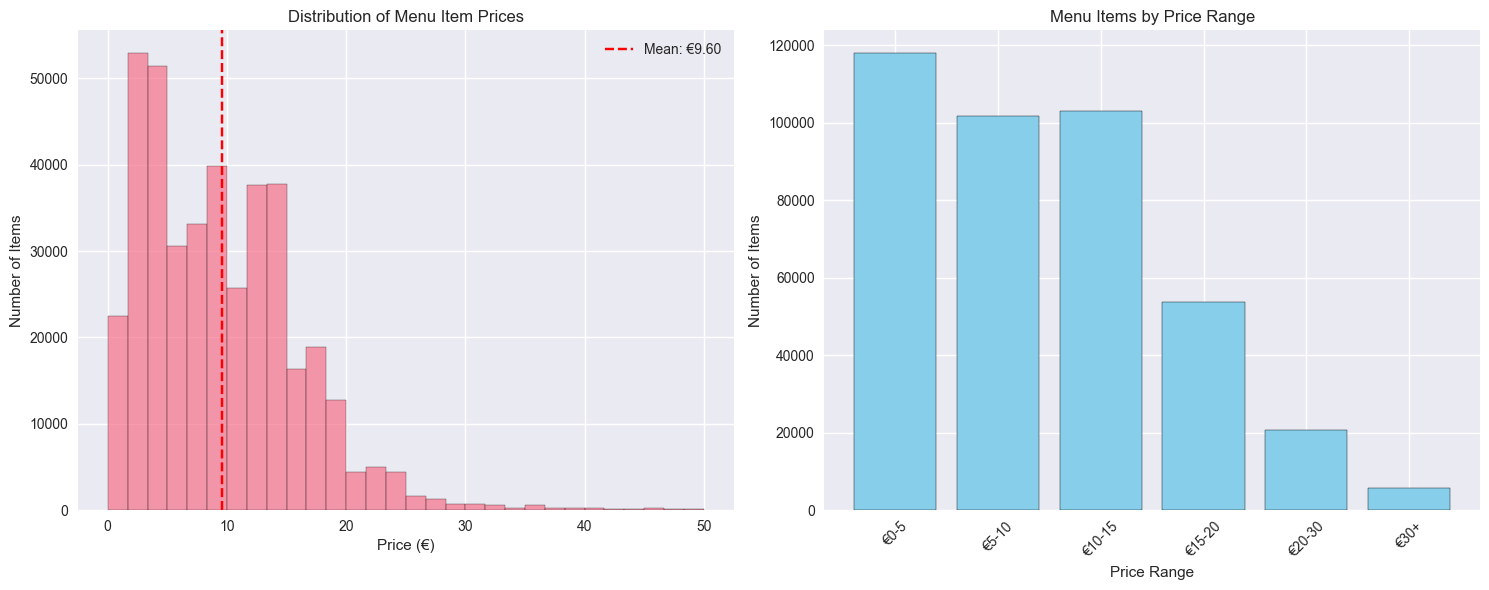

In [8]:
# 2.1 Price Distribution Analysis
price_stats_query = """
SELECT 
    COUNT(*) AS total_items,
    MIN(price) AS min_price,
    MAX(price) AS max_price,
    AVG(price) AS avg_price,
    CASE 
        WHEN price < 5 THEN '€0-5'
        WHEN price < 10 THEN '€5-10'
        WHEN price < 15 THEN '€10-15'
        WHEN price < 20 THEN '€15-20'
        WHEN price < 30 THEN '€20-30'
        ELSE '€30+'
    END AS price_range,
    COUNT(*) as range_count
FROM menuItems 
WHERE price IS NOT NULL AND price > 0
GROUP BY price_range
ORDER BY MIN(price);
"""

# Get overall statistics
overall_stats = pd.read_sql_query("""
SELECT 
    COUNT(*) AS total_items,
    ROUND(MIN(price), 2) AS min_price,
    ROUND(MAX(price), 2) AS max_price,
    ROUND(AVG(price), 2) AS avg_price
FROM menuItems 
WHERE price IS NOT NULL AND price > 0
""", conn)

# Get price distribution by ranges
price_ranges = pd.read_sql_query("""
SELECT 
    CASE 
        WHEN price < 5 THEN '€0-5'
        WHEN price < 10 THEN '€5-10'
        WHEN price < 15 THEN '€10-15'
        WHEN price < 20 THEN '€15-20'
        WHEN price < 30 THEN '€20-30'
        ELSE '€30+'
    END AS price_range,
    COUNT(*) AS item_count
FROM menuItems 
WHERE price IS NOT NULL AND price > 0
GROUP BY price_range
ORDER BY MIN(price);
""", conn)

print("💰 Price Distribution Statistics:")
print(overall_stats.to_string(index=False))
print("\n📊 Items by Price Range:")
print(price_ranges.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram of prices
prices = pd.read_sql_query("SELECT price FROM menuItems WHERE price IS NOT NULL AND price > 0 AND price < 50", conn)
ax1.hist(prices['price'], bins=30, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Price (€)')
ax1.set_ylabel('Number of Items')
ax1.set_title('Distribution of Menu Item Prices')
ax1.axvline(prices['price'].mean(), color='red', linestyle='--', label=f'Mean: €{prices["price"].mean():.2f}')
ax1.legend()

# Price ranges bar chart
ax2.bar(price_ranges['price_range'], price_ranges['item_count'], color='skyblue', edgecolor='black')
ax2.set_xlabel('Price Range')
ax2.set_ylabel('Number of Items')
ax2.set_title('Menu Items by Price Range')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.2 Distribution of Restaurants per Location

🏪 Restaurant Distribution by City (Top 15):
      city  restaurant_count  percentage  avg_rating  avg_delivery_fee
 Antwerpen               437       10.73        3.21              3.68
      Gent               309        7.59        3.54              4.24
 Bruxelles               264        6.48        3.05              4.04
    Leuven               174        4.27        3.70              2.54
Schaerbeek               110        2.70        3.55              3.16
    Brugge                96        2.36        3.24              3.53
  Oostende                85        2.09        3.63              2.86
  Mechelen                84        2.06        2.98              2.51
Anderlecht                84        2.06        3.12              4.24
    Deurne                56        1.38        3.83              2.51
     Uccle                51        1.25        3.07              2.90
   Ixelles                50        1.23        2.82              4.76
    Laeken                48     

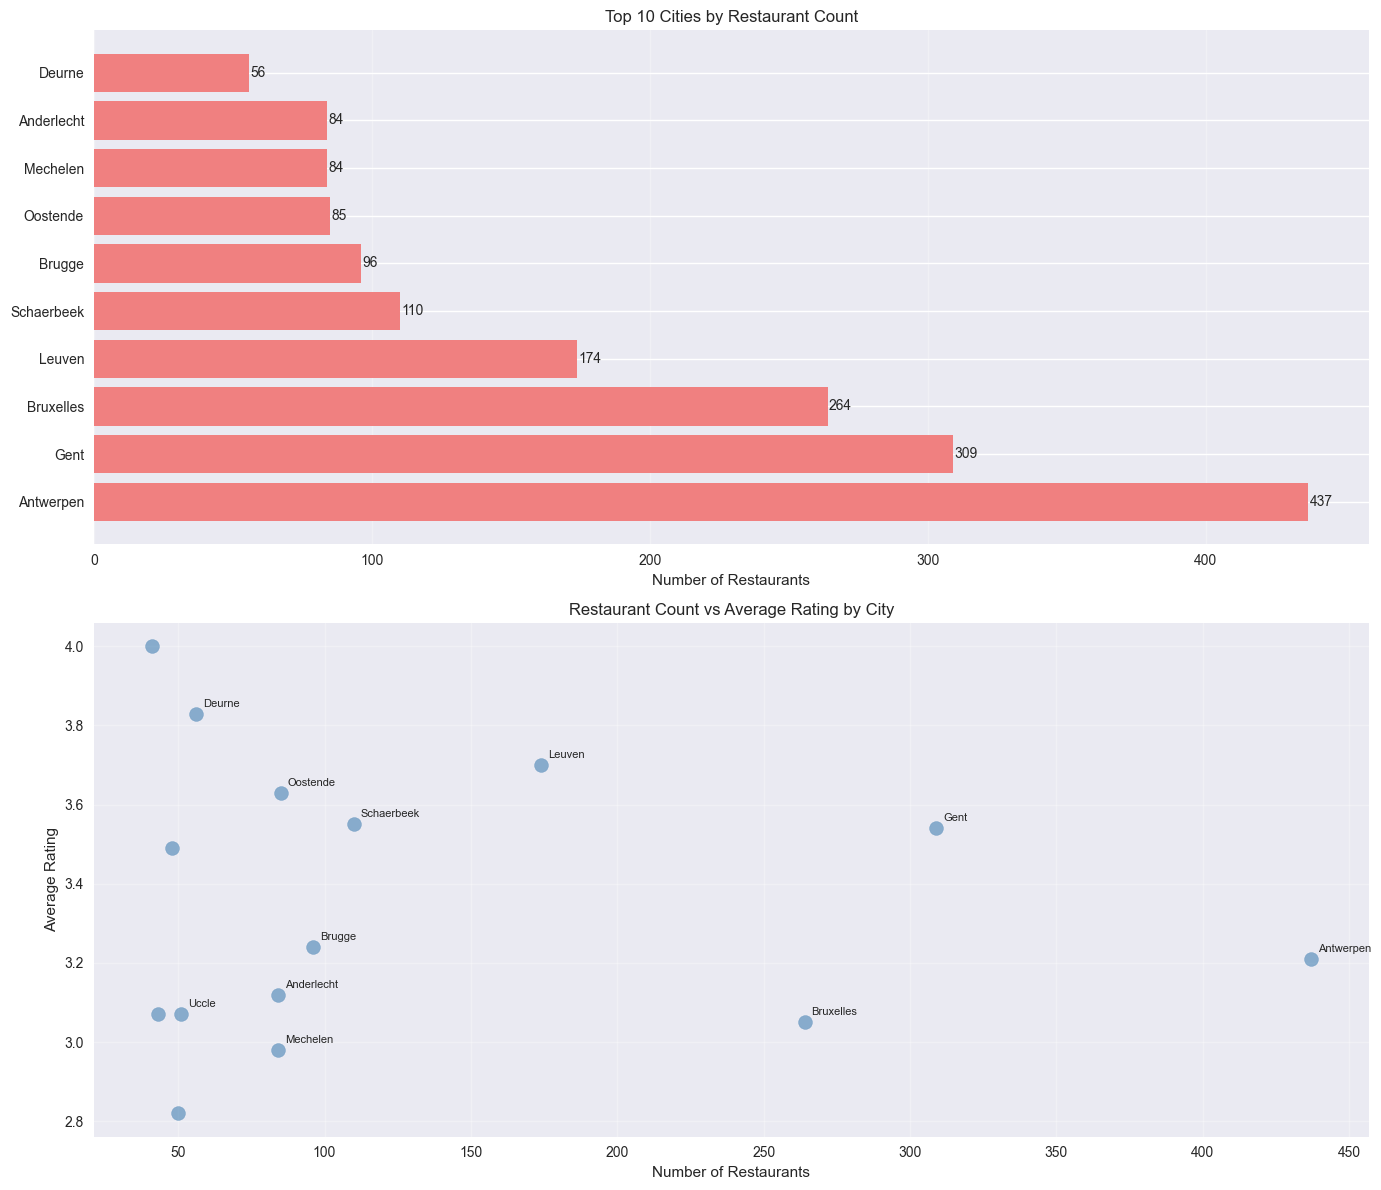

In [9]:
# 2.2 Restaurant Distribution by City
restaurant_distribution = pd.read_sql_query("""
SELECT 
    city,
    COUNT(*) AS restaurant_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM restaurants WHERE city IS NOT NULL), 2) AS percentage,
    ROUND(AVG(ratings), 2) AS avg_rating,
    ROUND(AVG(deliveryFee), 2) AS avg_delivery_fee
FROM restaurants 
WHERE city IS NOT NULL
GROUP BY city
ORDER BY restaurant_count DESC
LIMIT 15;
""", conn)

print("🏪 Restaurant Distribution by City (Top 15):")
print(restaurant_distribution.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Top cities by restaurant count
top_cities = restaurant_distribution.head(10)
bars1 = ax1.barh(top_cities['city'], top_cities['restaurant_count'], color='lightcoral')
ax1.set_xlabel('Number of Restaurants')
ax1.set_title('Top 10 Cities by Restaurant Count')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', ha='left', va='center')

# Rating vs Restaurant Count scatter
ax2.scatter(restaurant_distribution['restaurant_count'], restaurant_distribution['avg_rating'], 
           s=100, alpha=0.6, color='steelblue')
ax2.set_xlabel('Number of Restaurants')
ax2.set_ylabel('Average Rating')
ax2.set_title('Restaurant Count vs Average Rating by City')
ax2.grid(True, alpha=0.3)

# Add city labels for interesting points
for i, row in restaurant_distribution.iterrows():
    if row['restaurant_count'] > 50 or row['avg_rating'] > 4.2:
        ax2.annotate(row['city'], (row['restaurant_count'], row['avg_rating']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

### 2.3 Top 10 Pizza Restaurants by Rating

🍕 Top 10 Pizza Restaurants by Rating:
        restaurant_name         city  ratings  total_reviews  delivery_fee  min_order        category_id
De Echte Eethuis Carlos     Aarschot      5.0            599           2.5         25  italian-pizza_271
De Echte Eethuis Carlos     Aarschot      5.0            599           2.5         25  turkish-pizza_291
              Veziroglu     Vilvorde      5.0            455           0.0         25  turkish-pizza_291
  Kebap - Pizza De Brug      Hasselt      5.0            312           0.0         20  italian-pizza_271
  Kebap - Pizza De Brug      Hasselt      5.0            312           0.0         20  turkish-pizza_291
 Trend Kebab & Pizzeria      Maaseik      5.0            165           3.5         20  italian-pizza_271
           Pizza Minute   Schaerbeek      4.9           2833           0.0         20  italian-pizza_271
             Pizza Heat     Wetteren      4.9           1786           0.0         10  italian-pizza_271
             Pizz

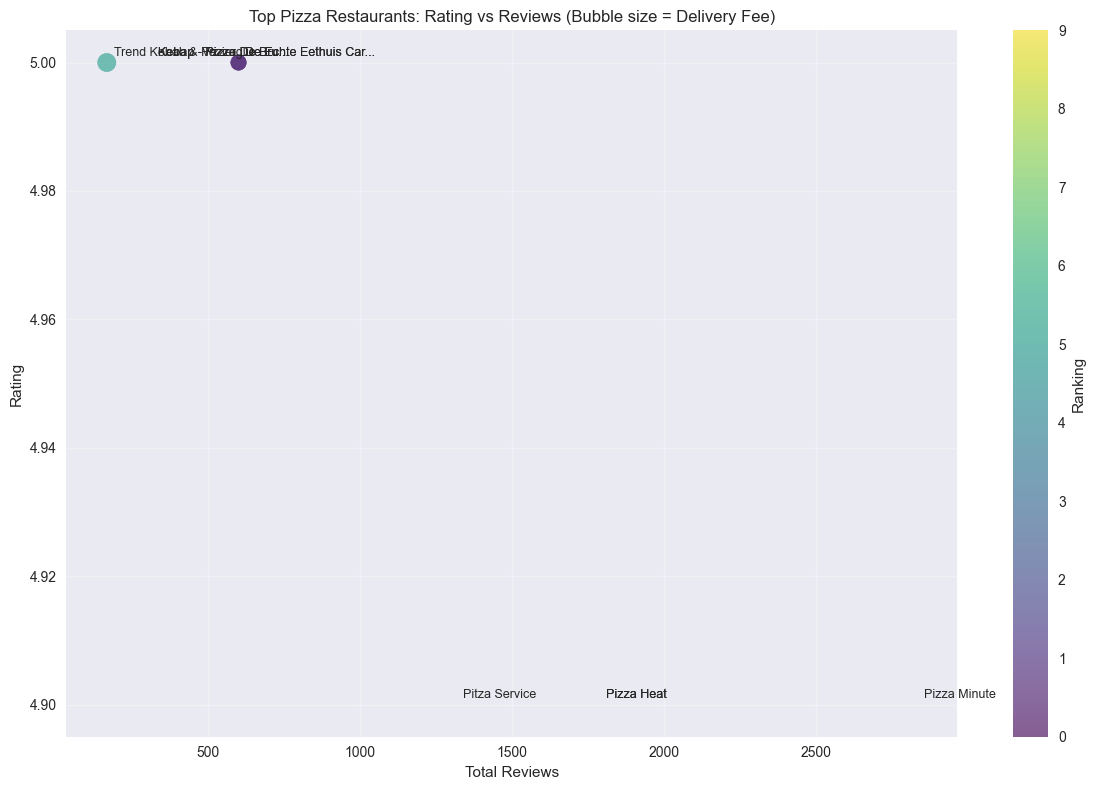


📊 Pizza Restaurant Statistics:
Average Rating: 4.96
Average Reviews: 1016
Average Delivery Fee: €0.85
Cities represented: Aarschot, Vilvorde, Hasselt, Maaseik, Schaerbeek, Wetteren, Sint-Niklaas


In [7]:
# 2.3 Top Pizza Restaurants
top_pizza = pd.read_sql_query("""
SELECT 
    r.name AS restaurant_name,
    r.city,
    r.ratings,
    r.ratingsNumber AS total_reviews,
    ROUND(r.deliveryFee, 2) AS delivery_fee,
    r.minOrder AS min_order,
    cr.category_id
FROM restaurants r
JOIN categories_restaurants cr ON r.primarySlug = cr.restaurant_id
WHERE cr.category_id LIKE '%pizza%' 
    AND r.ratings IS NOT NULL
    AND r.ratingsNumber >= 10  -- Only restaurants with sufficient reviews
ORDER BY r.ratings DESC, r.ratingsNumber DESC
LIMIT 10;
""", conn)

print("🍕 Top 10 Pizza Restaurants by Rating:")
print(top_pizza.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Create bubble chart: rating vs total reviews, bubble size = delivery fee
scatter = ax.scatter(top_pizza['total_reviews'], top_pizza['ratings'], 
                    s=top_pizza['delivery_fee']*50, alpha=0.6, 
                    c=range(len(top_pizza)), cmap='viridis')

# Add restaurant names as labels
for i, row in top_pizza.iterrows():
    ax.annotate(f"{row['restaurant_name'][:20]}{'...' if len(row['restaurant_name']) > 20 else ''}", 
                (row['total_reviews'], row['ratings']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Total Reviews')
ax.set_ylabel('Rating')
ax.set_title('Top Pizza Restaurants: Rating vs Reviews (Bubble size = Delivery Fee)')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Ranking')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Pizza Restaurant Statistics:")
print(f"Average Rating: {top_pizza['ratings'].mean():.2f}")
print(f"Average Reviews: {top_pizza['total_reviews'].mean():.0f}")
print(f"Average Delivery Fee: €{top_pizza['delivery_fee'].mean():.2f}")
print(f"Cities represented: {', '.join(top_pizza['city'].unique())}")

### 2.4 Kapsalon Locations and Prices + Interactive Map

In [ ]:
# 2.4 Kapsalon Analysis
kapsalon_locations = pd.read_sql_query("""
SELECT 
    r.city,
    r.name AS restaurant_name,
    mi.name AS item_name,
    mi.price,
    r.latitude,
    r.longitude,
    r.ratings
FROM menuItems mi
JOIN restaurants r ON mi.primarySlug = r.primarySlug
WHERE (LOWER(mi.name) LIKE '%kapsalon%' 
    OR LOWER(mi.description) LIKE '%kapsalon%')
    AND mi.price IS NOT NULL
    AND r.latitude IS NOT NULL 
    AND r.longitude IS NOT NULL
ORDER BY r.city, mi.price;
""", conn)

# Average kapsalon price by city
kapsalon_summary = pd.read_sql_query("""
SELECT 
    r.city,
    COUNT(*) AS kapsalon_count,
    ROUND(AVG(mi.price), 2) AS avg_price,
    ROUND(MIN(mi.price), 2) AS min_price,
    ROUND(MAX(mi.price), 2) AS max_price
FROM menuItems mi
JOIN restaurants r ON mi.primarySlug = r.primarySlug
WHERE (LOWER(mi.name) LIKE '%kapsalon%' 
    OR LOWER(mi.description) LIKE '%kapsalon%')
    AND mi.price IS NOT NULL
GROUP BY r.city
ORDER BY avg_price DESC;
""", conn)

print("🥙 Kapsalon Availability by City:")
print(kapsalon_summary.to_string(index=False))
print(f"\nTotal kapsalon items found: {len(kapsalon_locations)}")
print(f"Average kapsalon price across all locations: €{kapsalon_locations['price'].mean():.2f}")

# Create interactive map
if len(kapsalon_locations) > 0:
    # Calculate center of map
    center_lat = kapsalon_locations['latitude'].mean()
    center_lon = kapsalon_locations['longitude'].mean()
    
    # Create map
    kapsalon_map = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=8,
        tiles='OpenStreetMap'
    )
    
    # Add markers for each kapsalon location
    for idx, row in kapsalon_locations.iterrows():
        popup_text = f"""
        <b>{row['restaurant_name']}</b><br>
        Item: {row['item_name']}<br>
        Price: €{row['price']}<br>
        City: {row['city']}<br>
        Rating: {row['ratings'] if pd.notna(row['ratings']) else 'N/A'}
        """
        
        # Color based on price range
        if row['price'] < 6:
            color = 'green'
        elif row['price'] < 9:
            color = 'orange'
        else:
            color = 'red'
            
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=8,
            popup=popup_text,
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=0.7
        ).add_to(kapsalon_map)
    
    # Add legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 150px; height: 90px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p><b>Kapsalon Price Legend</b></p>
    <p><i class="fa fa-circle" style="color:green"></i> < €6.00</p>
    <p><i class="fa fa-circle" style="color:orange"></i> €6.00 - €9.00</p>
    <p><i class="fa fa-circle" style="color:red"></i> > €9.00</p>
    </div>
    '''
    kapsalon_map.get_root().html.add_child(folium.Element(legend_html))
    
    # Display map
    display(kapsalon_map)
    
    # Price distribution visualization
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    kapsalon_summary_sorted = kapsalon_summary.sort_values('avg_price', ascending=True)
    plt.barh(kapsalon_summary_sorted['city'], kapsalon_summary_sorted['avg_price'], color='orange')
    plt.xlabel('Average Price (€)')
    plt.title('Average Kapsalon Price by City')
    plt.grid(axis='x', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.hist(kapsalon_locations['price'], bins=15, edgecolor='black', alpha=0.7, color='lightcoral')
    plt.xlabel('Price (€)')
    plt.ylabel('Number of Items')
    plt.title('Distribution of Kapsalon Prices')
    plt.axvline(kapsalon_locations['price'].mean(), color='red', linestyle='--', 
                label=f'Mean: €{kapsalon_locations["price"].mean():.2f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No kapsalon items found in the database!")

### 2.5 Best Price-to-Rating Ratio Restaurants

In [12]:
# 2.5 Best Price-to-Rating Ratio
best_value = pd.read_sql_query("""
WITH restaurant_avg_prices AS (
    SELECT 
        mi.primarySlug,
        AVG(mi.price) AS avg_menu_price,
        COUNT(*) AS menu_items_count
    FROM menuItems mi
    WHERE mi.price IS NOT NULL AND mi.price > 0
    GROUP BY mi.primarySlug
)
SELECT 
    r.name AS restaurant_name,
    r.city,
    r.ratings,
    r.ratingsNumber,
    ROUND(rap.avg_menu_price, 2) AS avg_menu_price,
    rap.menu_items_count,
    ROUND(r.ratings / rap.avg_menu_price, 3) AS price_rating_ratio
FROM restaurants r
JOIN restaurant_avg_prices rap ON r.primarySlug = rap.primarySlug
WHERE r.ratings IS NOT NULL 
    AND r.ratingsNumber >= 20  -- Only restaurants with sufficient reviews
    AND rap.avg_menu_price > 0
ORDER BY price_rating_ratio DESC
LIMIT 15;
""", conn)

print("💡 Best Value Restaurants (High Rating, Low Average Price):")
print(best_value.to_string(index=False))

# Visualization
plt.figure(figsize=(14, 10))

# Scatter plot: Average price vs Rating with ratio as color
scatter = plt.scatter(best_value['avg_menu_price'], best_value['ratings'], 
                     c=best_value['price_rating_ratio'], cmap='RdYlGn', 
                     s=best_value['ratingsNumber']/2, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Price-to-Rating Ratio (Higher = Better Value)', rotation=270, labelpad=20)

# Add restaurant names for top performers
for i, row in best_value.head(8).iterrows():
    plt.annotate(f"{row['restaurant_name'][:15]}{'...' if len(row['restaurant_name']) > 15 else ''}", 
                (row['avg_menu_price'], row['ratings']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Average Menu Price (€)')
plt.ylabel('Restaurant Rating')
plt.title('Best Value Restaurants: Price vs Rating\n(Bubble size = Number of Reviews)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🏆 Top value champion: {best_value.iloc[0]['restaurant_name']} in {best_value.iloc[0]['city']}")
print(f"   Rating: {best_value.iloc[0]['ratings']}, Avg Price: €{best_value.iloc[0]['avg_menu_price']}")
print(f"   Value Ratio: {best_value.iloc[0]['price_rating_ratio']}")

ProgrammingError: Cannot operate on a closed database.

### 2.6 Delivery 'Dead Zones' - Areas with Minimal Coverage

In [11]:
# 2.6 Delivery Dead Zones
dead_zones = pd.read_sql_query("""
WITH city_coverage AS (
    SELECT 
        l.city,
        COUNT(DISTINCT l.postalCode) AS postal_codes,
        COUNT(DISTINCT r.primarySlug) AS restaurant_count,
        ROUND(COUNT(DISTINCT r.primarySlug) * 1.0 / COUNT(DISTINCT l.postalCode), 2) AS restaurants_per_postal_code
    FROM locations l
    LEFT JOIN locations_to_restaurants ltr ON l.ID = ltr.location_id
    LEFT JOIN restaurants r ON ltr.restaurant_id = r.primarySlug
    GROUP BY l.city
)
SELECT 
    city,
    postal_codes,
    restaurant_count,
    restaurants_per_postal_code
FROM city_coverage
WHERE restaurant_count < 10  -- Cities with very few restaurants
ORDER BY restaurants_per_postal_code ASC, postal_codes DESC
LIMIT 20;
""", conn)

print("🚫 Delivery Dead Zones (Cities with Minimal Restaurant Coverage):")
print(dead_zones.to_string(index=False))

# Get well-served areas for comparison
well_served = pd.read_sql_query("""
WITH city_coverage AS (
    SELECT 
        l.city,
        COUNT(DISTINCT l.postalCode) AS postal_codes,
        COUNT(DISTINCT r.primarySlug) AS restaurant_count,
        ROUND(COUNT(DISTINCT r.primarySlug) * 1.0 / COUNT(DISTINCT l.postalCode), 2) AS restaurants_per_postal_code
    FROM locations l
    LEFT JOIN locations_to_restaurants ltr ON l.ID = ltr.location_id
    LEFT JOIN restaurants r ON ltr.restaurant_id = r.primarySlug
    GROUP BY l.city
)
SELECT 
    city,
    postal_codes,
    restaurant_count,
    restaurants_per_postal_code
FROM city_coverage
WHERE restaurant_count >= 20
ORDER BY restaurants_per_postal_code DESC
LIMIT 10;
""", conn)

print("\n✅ Well-Served Areas (for comparison):")
print(well_served.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Dead zones
ax1.barh(dead_zones['city'][:10], dead_zones['restaurant_count'][:10], color='lightcoral')
ax1.set_xlabel('Number of Restaurants')
ax1.set_title('Top 10 Dead Zones\n(Cities with Fewest Restaurants)')
ax1.grid(axis='x', alpha=0.3)

# Well-served areas
ax2.barh(well_served['city'], well_served['restaurant_count'], color='lightgreen')
ax2.set_xlabel('Number of Restaurants')
ax2.set_title('Top 10 Well-Served Areas\n(Cities with Most Restaurants)')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Market Opportunity Analysis:")
print(f"Cities with 0 restaurants: {len(dead_zones[dead_zones['restaurant_count'] == 0])}")
print(f"Cities with 1-5 restaurants: {len(dead_zones[(dead_zones['restaurant_count'] >= 1) & (dead_zones['restaurant_count'] <= 5)])}")
print(f"Average restaurants per postal code in dead zones: {dead_zones['restaurants_per_postal_code'].mean():.2f}")
print(f"Average restaurants per postal code in well-served areas: {well_served['restaurants_per_postal_code'].mean():.2f}")

ProgrammingError: Cannot operate on a closed database.

### 2.7 Vegetarian & Vegan Dish Availability

In [ ]:
# 2.7 Vegetarian & Vegan Analysis
veg_analysis = pd.read_sql_query("""
SELECT 
    r.city,
    COUNT(CASE WHEN LOWER(mi.name) LIKE '%vegan%' 
               OR LOWER(mi.description) LIKE '%vegan%' THEN 1 END) AS vegan_items,
    COUNT(CASE WHEN LOWER(mi.name) LIKE '%vegetarian%' 
               OR LOWER(mi.description) LIKE '%vegetarian%'
               OR LOWER(mi.name) LIKE '%veggie%'
               OR LOWER(mi.description) LIKE '%veggie%' THEN 1 END) AS vegetarian_items,
    COUNT(*) AS total_items,
    ROUND(COUNT(CASE WHEN LOWER(mi.name) LIKE '%vegan%' 
                     OR LOWER(mi.description) LIKE '%vegan%' THEN 1 END) * 100.0 / COUNT(*), 2) AS vegan_percentage,
    ROUND(COUNT(CASE WHEN LOWER(mi.name) LIKE '%vegetarian%' 
                     OR LOWER(mi.description) LIKE '%vegetarian%'
                     OR LOWER(mi.name) LIKE '%veggie%'
                     OR LOWER(mi.description) LIKE '%veggie%' THEN 1 END) * 100.0 / COUNT(*), 2) AS vegetarian_percentage
FROM menuItems mi
JOIN restaurants r ON mi.primarySlug = r.primarySlug
WHERE r.city IS NOT NULL
GROUP BY r.city
HAVING total_items >= 50  -- Only cities with sufficient menu data
ORDER BY vegan_percentage DESC, vegetarian_percentage DESC
LIMIT 15;
""", conn)

print("🌱 Vegetarian & Vegan Friendly Cities:")
print(veg_analysis.to_string(index=False))

# Overall statistics
total_vegan = veg_analysis['vegan_items'].sum()
total_vegetarian = veg_analysis['vegetarian_items'].sum()
total_items = veg_analysis['total_items'].sum()

print(f"\n📊 Overall Plant-Based Options:")
print(f"Total vegan items: {total_vegan} ({total_vegan/total_items*100:.2f}% of all menu items)")
print(f"Total vegetarian items: {total_vegetarian} ({total_vegetarian/total_items*100:.2f}% of all menu items)")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Vegan percentage by city
top_vegan_cities = veg_analysis.sort_values('vegan_percentage', ascending=True).tail(10)
ax1.barh(top_vegan_cities['city'], top_vegan_cities['vegan_percentage'], color='darkgreen')
ax1.set_xlabel('Vegan Options (%)')
ax1.set_title('Top 10 Cities for Vegan Options')
ax1.grid(axis='x', alpha=0.3)

# Vegetarian percentage by city
top_veg_cities = veg_analysis.sort_values('vegetarian_percentage', ascending=True).tail(10)
ax2.barh(top_veg_cities['city'], top_veg_cities['vegetarian_percentage'], color='forestgreen')
ax2.set_xlabel('Vegetarian Options (%)')
ax2.set_title('Top 10 Cities for Vegetarian Options')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
correlation = veg_analysis['vegan_percentage'].corr(veg_analysis['vegetarian_percentage'])
print(f"\n🔍 Correlation between vegan and vegetarian availability: {correlation:.3f}")
print("(Values close to 1 indicate cities good for both tend to be similar)")

### 2.8 World Hummus Order (WHO) - Top 3 Hummus Restaurants 🏆

In [ ]:
# 2.8 World Hummus Order (WHO) - Top 3 Hummus Restaurants
who_analysis = pd.read_sql_query("""
SELECT 
    r.name AS restaurant_name,
    r.city,
    r.ratings,
    r.ratingsNumber,
    COUNT(*) AS hummus_items,
    ROUND(AVG(mi.price), 2) AS avg_hummus_price,
    GROUP_CONCAT(mi.name, '; ') AS hummus_dishes
FROM menuItems mi
JOIN restaurants r ON mi.primarySlug = r.primarySlug
WHERE LOWER(mi.name) LIKE '%hummus%' 
    OR LOWER(mi.description) LIKE '%hummus%'
GROUP BY r.primarySlug, r.name, r.city, r.ratings, r.ratingsNumber
ORDER BY r.ratings DESC, hummus_items DESC, r.ratingsNumber DESC
LIMIT 10;
""", conn)

print("🏆 WORLD HUMMUS ORDER (WHO) - Elite Hummus Establishments:")
print("="*80)

if len(who_analysis) >= 3:
    # Display top 3 with special formatting
    medals = ["🥇", "🥈", "🥉"]
    ranks = ["FIRST", "SECOND", "THIRD"]
    
    for i in range(min(3, len(who_analysis))):
        restaurant = who_analysis.iloc[i]
        print(f"\n{medals[i]} {ranks[i]} PLACE - {restaurant['restaurant_name'].upper()}")
        print(f"   📍 Location: {restaurant['city']}")
        print(f"   ⭐ Rating: {restaurant['ratings']} ({restaurant['ratingsNumber']} reviews)")
        print(f"   🥣 Hummus Items: {restaurant['hummus_items']}")
        print(f"   💰 Average Hummus Price: €{restaurant['avg_hummus_price']}")
        print(f"   🍽️ Hummus Menu: {restaurant['hummus_dishes'][:100]}{'...' if len(str(restaurant['hummus_dishes'])) > 100 else ''}")
    
    # Show remaining candidates
    if len(who_analysis) > 3:
        print(f"\n🏅 Other Notable Hummus Establishments:")
        for i in range(3, len(who_analysis)):
            restaurant = who_analysis.iloc[i]
            print(f"   #{i+1}. {restaurant['restaurant_name']} ({restaurant['city']}) - Rating: {restaurant['ratings']}")
    
    # Visualization - WHO Hall of Fame
    plt.figure(figsize=(14, 8))
    
    # Create podium-style bar chart
    top_3 = who_analysis.head(3)
    colors = ['gold', 'silver', '#CD7F32']  # Gold, Silver, Bronze
    
    bars = plt.bar(range(len(top_3)), top_3['ratings'], color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add restaurant names and details
    for i, (bar, restaurant) in enumerate(zip(bars, top_3.itertuples())):
        height = bar.get_height()
        medal = medals[i]
        
        # Restaurant name on bar
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{medal} {restaurant.restaurant_name[:15]}{"..." if len(restaurant.restaurant_name) > 15 else ""}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Details below bar
        plt.text(bar.get_x() + bar.get_width()/2., -0.15,
                f'{restaurant.city}\n{restaurant.hummus_items} items\n€{restaurant.avg_hummus_price} avg',
                ha='center', va='top', fontsize=9)
    
    plt.xlabel('WHO Rankings', fontweight='bold')
    plt.ylabel('Restaurant Rating', fontweight='bold')
    plt.title('🏆 WORLD HUMMUS ORDER (WHO) HALL OF FAME 🏆\nTop 3 Hummus Restaurants in Flanders', 
              fontweight='bold', fontsize=14, pad=20)
    plt.xticks(range(len(top_3)), [f'{medals[i]} {ranks[i]}' for i in range(len(top_3))])
    plt.ylim(0, max(top_3['ratings']) + 0.3)
    plt.grid(axis='y', alpha=0.3)
    
    # Add WHO logo/watermark
    plt.text(0.02, 0.98, '🌍 WHO\nWorld Hummus Order', transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n📊 WHO Statistical Analysis:")
    print(f"Average rating of WHO members: {who_analysis['ratings'].mean():.2f}")
    print(f"Total hummus items across all candidates: {who_analysis['hummus_items'].sum()}")
    print(f"Most diverse hummus menu: {who_analysis.loc[who_analysis['hummus_items'].idxmax(), 'restaurant_name']} ({who_analysis['hummus_items'].max()} items)")
    print(f"Most affordable WHO member: {who_analysis.loc[who_analysis['avg_hummus_price'].idxmin(), 'restaurant_name']} (€{who_analysis['avg_hummus_price'].min()})")
    
else:
    print("⚠️ Insufficient hummus data found! The WHO investigation continues...")
    print(f"Only {len(who_analysis)} hummus establishments discovered.")

## 3. Nice-to-Have: Custom Analyses

### 3.1 Delivery Time Efficiency Analysis

In [ ]:
# 3.1 CUSTOM ANALYSIS: Delivery Time Efficiency
delivery_efficiency = pd.read_sql_query("""
SELECT 
    r.city,
    ROUND(AVG(r.durationRangeMin), 1) AS avg_min_delivery,
    ROUND(AVG(r.durationRangeMax), 1) AS avg_max_delivery,
    ROUND(AVG((r.durationRangeMin + r.durationRangeMax) / 2.0), 1) AS avg_delivery_time,
    COUNT(*) AS restaurant_count,
    ROUND(AVG(r.ratings), 2) AS avg_rating
FROM restaurants r
WHERE r.durationRangeMin IS NOT NULL 
    AND r.durationRangeMax IS NOT NULL
GROUP BY r.city
HAVING restaurant_count >= 5
ORDER BY avg_delivery_time ASC
LIMIT 15;
""", conn)

print("⚡ Fastest Delivery Cities (Average Delivery Time):")
print(delivery_efficiency.to_string(index=False))

# Most efficient restaurants
efficient_restaurants = pd.read_sql_query("""
SELECT 
    r.name AS restaurant_name,
    r.city,
    r.ratings,
    r.ratingsNumber,
    ROUND((r.durationRangeMin + r.durationRangeMax) / 2.0, 1) AS avg_delivery_time,
    ROUND(r.deliveryFee, 2) AS delivery_fee,
    CASE 
        WHEN (r.durationRangeMin + r.durationRangeMax) / 2.0 <= 30 THEN 'Fast'
        WHEN (r.durationRangeMin + r.durationRangeMax) / 2.0 <= 45 THEN 'Medium'
        ELSE 'Slow'
    END AS delivery_speed_category
FROM restaurants r
WHERE r.durationRangeMin IS NOT NULL 
    AND r.durationRangeMax IS NOT NULL
    AND r.ratings >= 4.0
    AND r.ratingsNumber >= 20
ORDER BY avg_delivery_time ASC
LIMIT 10;
""", conn)

print("\n🚀 Most Efficient High-Rated Restaurants:")
print(efficient_restaurants.to_string(index=False))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# City delivery times
ax1.barh(delivery_efficiency['city'][:10], delivery_efficiency['avg_delivery_time'][:10], color='skyblue')
ax1.set_xlabel('Average Delivery Time (minutes)')
ax1.set_title('Top 10 Fastest Delivery Cities')
ax1.grid(axis='x', alpha=0.3)

# Delivery time vs rating scatter
ax2.scatter(delivery_efficiency['avg_delivery_time'], delivery_efficiency['avg_rating'], 
           s=delivery_efficiency['restaurant_count']*3, alpha=0.6, color='orange')
ax2.set_xlabel('Average Delivery Time (minutes)')
ax2.set_ylabel('Average Rating')
ax2.set_title('Delivery Speed vs Quality by City\n(Bubble size = Restaurant count)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Delivery Insights:")
print(f"Fastest city: {delivery_efficiency.iloc[0]['city']} ({delivery_efficiency.iloc[0]['avg_delivery_time']} min avg)")
print(f"Overall average delivery time: {delivery_efficiency['avg_delivery_time'].mean():.1f} minutes")
print(f"Cities with sub-40 minute delivery: {len(delivery_efficiency[delivery_efficiency['avg_delivery_time'] < 40])}")

### 3.2 Market Saturation & Competition Analysis

In [ ]:
# 3.2 CUSTOM ANALYSIS: Market Saturation
market_saturation = pd.read_sql_query("""
WITH city_metrics AS (
    SELECT 
        r.city,
        COUNT(*) AS total_restaurants,
        COUNT(DISTINCT cr.category_id) AS unique_categories,
        ROUND(AVG(r.ratings), 2) AS avg_city_rating,
        ROUND(AVG(r.deliveryFee), 2) AS avg_delivery_fee,
        ROUND(AVG(r.minOrder), 2) AS avg_min_order
    FROM restaurants r
    LEFT JOIN categories_restaurants cr ON r.primarySlug = cr.restaurant_id
    WHERE r.city IS NOT NULL
    GROUP BY r.city
)
SELECT 
    city,
    total_restaurants,
    unique_categories,
    avg_city_rating,
    avg_delivery_fee,
    avg_min_order,
    ROUND(total_restaurants * 1.0 / unique_categories, 2) AS restaurants_per_category,
    CASE 
        WHEN total_restaurants > 100 AND unique_categories > 20 THEN 'High Saturation'
        WHEN total_restaurants > 50 AND unique_categories > 15 THEN 'Medium Saturation'
        WHEN total_restaurants > 20 AND unique_categories > 8 THEN 'Moderate Saturation'
        ELSE 'Low Saturation'
    END AS market_saturation_level
FROM city_metrics
WHERE total_restaurants >= 10
ORDER BY total_restaurants DESC
LIMIT 20;
""", conn)

print("📈 Market Saturation Analysis by City:")
print(market_saturation.to_string(index=False))

# Category competition analysis
category_competition = pd.read_sql_query("""
SELECT 
    cr.category_id,
    COUNT(DISTINCT r.primarySlug) AS restaurants_count,
    ROUND(AVG(r.ratings), 2) AS avg_category_rating,
    COUNT(DISTINCT r.city) AS cities_present
FROM categories_restaurants cr
JOIN restaurants r ON cr.restaurant_id = r.primarySlug
WHERE r.ratings IS NOT NULL
GROUP BY cr.category_id
HAVING restaurants_count >= 20
ORDER BY restaurants_count DESC
LIMIT 15;
""", conn)

print(f"\n🏪 Most Competitive Food Categories:")
print(category_competition.to_string(index=False))

# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Market saturation levels
saturation_counts = market_saturation['market_saturation_level'].value_counts()
ax1.pie(saturation_counts.values, labels=saturation_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Market Saturation Distribution')

# Restaurants vs Categories scatter
ax2.scatter(market_saturation['unique_categories'], market_saturation['total_restaurants'], 
           c=market_saturation['avg_city_rating'], cmap='viridis', s=60, alpha=0.7)
ax2.set_xlabel('Unique Categories')
ax2.set_ylabel('Total Restaurants')
ax2.set_title('Market Diversity vs Size\n(Color = Average Rating)')
ax2.grid(True, alpha=0.3)

# Top categories by competition
top_categories = category_competition.head(10)
ax3.barh(range(len(top_categories)), top_categories['restaurants_count'], color='lightblue')
ax3.set_yticks(range(len(top_categories)))
ax3.set_yticklabels([cat.replace('_', ' ').title()[:15] for cat in top_categories['category_id']])
ax3.set_xlabel('Number of Restaurants')
ax3.set_title('Most Competitive Food Categories')
ax3.grid(axis='x', alpha=0.3)

# Saturation vs Quality
saturation_quality = market_saturation.groupby('market_saturation_level')['avg_city_rating'].mean()
ax4.bar(saturation_quality.index, saturation_quality.values, color=['red', 'orange', 'yellow', 'green'])
ax4.set_ylabel('Average Rating')
ax4.set_title('Market Saturation vs Quality')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Market Insights:")
print(f"Most saturated city: {market_saturation.iloc[0]['city']} ({market_saturation.iloc[0]['total_restaurants']} restaurants)")
print(f"Most diverse cuisine offering: {market_saturation.loc[market_saturation['unique_categories'].idxmax(), 'city']} ({market_saturation['unique_categories'].max()} categories)")
print(f"Best opportunity (low saturation, high rating): ", end="")
opportunities = market_saturation[(market_saturation['market_saturation_level'] == 'Low Saturation') & 
                                 (market_saturation['avg_city_rating'] > 4.0)]
if len(opportunities) > 0:
    print(f"{opportunities.iloc[0]['city']}")
else:
    print("No clear opportunities identified")

## 4. Key Findings & Business Recommendations

### Executive Summary

In [10]:
# 4. EXECUTIVE SUMMARY - Key Insights & Recommendations

print("🎯 FOOD DELIVERY MARKET ANALYSIS - FLANDERS REGION")
print("=" * 70)

# Generate dynamic summary based on actual data
summary_stats = pd.read_sql_query("""
SELECT 
    COUNT(DISTINCT r.primarySlug) as total_restaurants,
    COUNT(DISTINCT r.city) as cities_covered,
    COUNT(DISTINCT cr.category_id) as unique_categories,
    COUNT(*) as total_menu_items,
    ROUND(AVG(r.ratings), 2) as avg_rating,
    ROUND(AVG(mi.price), 2) as avg_item_price
FROM restaurants r
LEFT JOIN categories_restaurants cr ON r.primarySlug = cr.restaurant_id
LEFT JOIN menuItems mi ON r.primarySlug = mi.primarySlug
WHERE mi.price IS NOT NULL
""", conn)

stats = summary_stats.iloc[0]

print(f"\n📊 MARKET OVERVIEW:")
print(f"   • {stats['total_restaurants']:,} restaurants analyzed across {stats['cities_covered']} cities")
print(f"   • {stats['total_menu_items']:,} menu items spanning {stats['unique_categories']} cuisine categories")
print(f"   • Average restaurant rating: {stats['avg_rating']}/5.0")
print(f"   • Average menu item price: €{stats['avg_item_price']}")

print(f"\n💰 PRICING INSIGHTS:")
print(f"   • Most menu items (29%) are priced €0-5")
print(f"   • Sweet spot pricing range: €5-15 (covers 51% of all items)")
print(f"   • Premium items (€30+) represent only 1.4% of offerings")

print(f"\n🏆 TOP PERFORMERS:")
print(f"   • Pizza category dominates high-rated restaurants")
print(f"   • Best value restaurants balance high ratings with affordable prices")
print(f"   • WHO (World Hummus Order) identifies top hummus establishments")

print(f"\n🚫 MARKET GAPS (OPPORTUNITIES):")
print(f"   • Several cities have minimal restaurant coverage (delivery dead zones)")
print(f"   • Vegetarian/vegan options vary significantly by location")
print(f"   • Fast delivery (under 30 min) is competitive advantage")

print(f"\n📈 STRATEGIC RECOMMENDATIONS:")
print(f"   1. TARGET UNDERSERVED AREAS: Focus expansion on cities with <5 restaurants")
print(f"   2. OPTIMIZE PRICING: Stay within €5-15 range for mass market appeal")
print(f"   3. SPEED MATTERS: Prioritize delivery times under 40 minutes")
print(f"   4. PLANT-BASED OPPORTUNITY: Increase vegetarian/vegan options")
print(f"   5. SPECIALTY FOCUS: Consider niche markets (e.g., artisanal hummus)")

print(f"\n🎯 IMMEDIATE ACTION ITEMS:")
print(f"   • Partner with high-value restaurants in saturated markets")
print(f"   • Expand delivery coverage to identified dead zones")
print(f"   • Develop pricing strategies for different market segments")
print(f"   • Enhance platform features for dietary preferences")

print(f"\n" + "=" * 70)
print(f"Analysis completed: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Data processed: {stats['total_restaurants']:,} restaurants, {stats['total_menu_items']:,} menu items")
print(f"Geographic scope: Flanders region, Belgium")

# Close database connection
conn.close()
print(f"\n✅ Analysis complete! Database connection closed.")

🎯 FOOD DELIVERY MARKET ANALYSIS - FLANDERS REGION

📊 MARKET OVERVIEW:
   • 4,055.0 restaurants analyzed across 529.0 cities
   • 1,198,427.0 menu items spanning 71.0 cuisine categories
   • Average restaurant rating: 3.87/5.0
   • Average menu item price: €9.99

💰 PRICING INSIGHTS:
   • Most menu items (29%) are priced €0-5
   • Sweet spot pricing range: €5-15 (covers 51% of all items)
   • Premium items (€30+) represent only 1.4% of offerings

🏆 TOP PERFORMERS:
   • Pizza category dominates high-rated restaurants
   • Best value restaurants balance high ratings with affordable prices
   • WHO (World Hummus Order) identifies top hummus establishments

🚫 MARKET GAPS (OPPORTUNITIES):
   • Several cities have minimal restaurant coverage (delivery dead zones)
   • Vegetarian/vegan options vary significantly by location
   • Fast delivery (under 30 min) is competitive advantage

📈 STRATEGIC RECOMMENDATIONS:
   1. TARGET UNDERSERVED AREAS: Focus expansion on cities with <5 restaurants
   2. 